## does this work
 - [x] M1 yaw/pitch - shift/~~tilt~~ response
     - [x] impedance matched
     - [x] overcoupled
 - [x] M2 yaw/pitch - shift/~~tilt~~ response
     - [x] impedance matched
     - [x] overcoupled
 - [ ] Difference between overcoupled and impedance matched
 - [ ] Add tilt response

In [1]:
import pykat
from pykat import finesse
from pykat.commands import *
import matplotlib.pyplot as plt
import numpy as np
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aplot
import pandas as pd

plt.rc('font', size= 10)
plt.rc('axes', titlesize= 10)

pykat.init_pykat_plotting(dpi=90,fmts=['png'])
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



### basekat

We deine a base file with all amplitude, beam parameter and cavity parameter detectors. also defines the cavity, in an overcoupled state with very high finesse.
 - May want to look at the effect of dithering the optics across some frequency spectrum

'which' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
basekat = finesse.kat()
basekat.verbose = False
dither = 10
basekat.parse(f"""

# Laser:
l laser 1 0 n0              # Laser 1W
s s0 0.5 n0 nmodin          # Distance from the laser to the first mirror M1
mod eo1 10M 0.3 3 pm nmodin nmodout
s s1 0.5 nmodout n1
pd1 pdh 10M -5 n1

# Cavity:
m M1 0.9999999999999 0.0000000000001 0 n1 n2            # Cavity mirror M1: R = 0.99, T = 0.01
s s_cav 0.25 n2 n3           # Cavity Length: L =  0.1 m
m M2 1 0 0 n3 n4            # Cavity mirror M2: R = 1, T = 0
attr M2 Rc 0.5              # Radius of curvature of M2 = 0.5 m
cav c1 M1 n2 M2 n3
trace 2

# Detectors
pd in n1*
pd circ n2
bp w0x x w0 n2
bp w0y y w0 n2
ad d00M1 0 0 0 n2
ad d10M1p 1 0 {dither} n2
ad d01M1p 0 1 {dither} n2
ad d10M1n 1 0 -{dither} n2
ad d01M1n 0 1 -{dither} n2
bp wM1x x w n2
bp wM1y y w n2
ad d00M2 0 0 0 n3
ad d10M2p 1 0 {dither} n3
ad d01M2p 0 1 {dither} n3
ad d10M2n 1 0 -{dither} n3
ad d01M2n 0 1 -{dither} n3
bp wM2x x w n3
bp wM2y y w n3
cp c1 x finesse
cp c1 x fsr
cp c1 x loss

# Commands:
trace 2
maxtem 1
yaxis lin re:im

""")

### xaxis

The xaxis command sweeps the mirror reflectivity, and sets mirror transmissivity to (1 - R)

Two versions: 
 - sweep only M1 RT, M2 RT is set to HR. This is the overcoupled case.
 - seeps RT for both M1 and M2. This is the impedance matched case.

In [3]:

imkat = basekat.deepcopy()
imkat.parse(f"""

xaxis M1 R lin 0.00001 0.95 10000
put M2 R $x1
func Tt = 1-$x1
put M1 T $Tt
put M2 T $Tt

""")

ockat = basekat.deepcopy()
ockat.parse(f"""

xaxis M1 R lin 0.00001 0.95 10000
func Tt = 1-$x1
put M1 T $Tt

""")


### M1 actuation

In [4]:
### M1 yaw

yawM1ockat = imkat.deepcopy()
yawM1ockat.parse(f"fsig sig1 M1 xbeta {dither} 0.0 1.0")
# yawM1ocout = yawM1ockat.run()

yawM1imkat = imkat.deepcopy()
yawM1imkat.parse(f"fsig sig1 M1 xbeta {dither} 0.0 1.0")
# yawM1imout = yawM1imkat.run()


### M1 pitch

pitM1ockat = ockat.deepcopy()
pitM1ockat.parse(f"fsig sig1 M1 ybeta {dither} 0.0 1.0")
# pitM1ocout = pitM1ockat.run()

pitM1imkat = ockat.deepcopy()
pitM1imkat.parse(f"fsig sig1 M1 ybeta {dither} 0.0 1.0")
# pitM1imout = pitM1imkat.run()


### M2 actuation

In [5]:
### M2 yaw

yawM2ockat = imkat.deepcopy()
yawM2ockat.parse(f"fsig sig1 M2 xbeta {dither} 0.0 1.0")
# yawM2ocout = yawM2ockat.run()

yawM2imkat = imkat.deepcopy()
yawM2imkat.parse(f"fsig sig1 M2 xbeta {dither} 0.0 1.0")
# yawM2imout = yawM2imkat.run()

### M2 pitch

pitM2ockat = ockat.deepcopy()
pitM2ockat.parse(f"fsig sig1 M2 ybeta {dither} 0.0 1.0")
# pit21ocout = pitM2ockat.run()

pitM2imkat = ockat.deepcopy()
pitM2imkat.parse(f"fsig sig1 M2 ybeta {dither} 0.0 1.0")
# pitM2imout = pitM2imkat.run()

### Sensing M1 actuation
#### Overcoupled

In [6]:
o = yawM1ockat.run()
ocxF = o["c1_x_finesse"]
ocx = o.x

# Calculate misalignment 
m100 = o[f'd00M1']
m110 = o[f'd10M1p']+o[f'd10M1n']
wm1 = o[f'wM1x'].real
Am110 = m110/m100

m200 = o[f'd00M2']
m210 = o[f'd10M2p']+o[f'd10M2n']
wm2 = o[f'wM2x'].real
Am210 = m210/m200

yawM1ocshiftM1 = (Am110.real*wm1)
yawM1ocshiftM2 = (Am210.real*wm2)


ValueError: could not convert string to float: '-1.#IND'

In [149]:
o = yawM2ockat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m110 = o[f'd10M1p']+o[f'd10M1n']
wm1 = o[f'wM1x'].real
Am110 = m110/m100

m200 = o[f'd00M2']
m210 = o[f'd10M2p']+o[f'd10M2n']
wm2 = o[f'wM2x'].real
Am210 = m210/m200

yawM2ocshiftM1 = (Am110.real*wm1)
yawM2ocshiftM2 = (Am210.real*wm2)

In [8]:
o = pitM1ockat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m101 = o[f'd01M1p']+o[f'd01M1n']
wm1 = o[f'wM1y'].real
Am101 = m101/m100

m200 = o[f'd00M2']
m201 = o[f'd01M2p']+o[f'd01M2n']
wm2 = o[f'wM2y'].real
Am201 = m201/m200

pitM1ocshiftM1 = (Am101.real*wm1)
pitM1ocshiftM2 = (Am201.real*wm2)

In [9]:
o = pitM2ockat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m101 = o[f'd01M1p']+o[f'd01M1n']
wm1 = o[f'wM1y'].real
Am101 = m101/m100

m200 = o[f'd00M2']
m201 = o[f'd01M2p']+o[f'd01M2n']
wm2 = o[f'wM2y'].real
Am201 = m201/m200

pitM2ocshiftM1 = (Am101.real*wm1)
pitM2ocshiftM2 = (Am201.real*wm2)

#### Impedance Matched

In [150]:
o = yawM1imkat.run()
imxF = o["c1_x_finesse"]
imx = o.x

# Calculate misalignment 
m100 = o[f'd00M1']
m110 = o[f'd10M1p']+o[f'd10M1n']
wm1 = o[f'wM1x'].real
Am110 = m110/m100

m200 = o[f'd00M2']
m210 = o[f'd10M2p']+o[f'd10M2n']
wm2 = o[f'wM2x'].real
Am210 = m210/m200

yawM1imshiftM1 = (Am110.real*wm1)
yawM1imshiftM2 = (Am210.real*wm2)


In [11]:
o = yawM2imkat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m110 = o[f'd10M1p']+o[f'd10M1n']
wm1 = o[f'wM1x'].real
Am110 = m110/m100

m200 = o[f'd00M2']
m210 = o[f'd10M2p']+o[f'd10M2n']
wm2 = o[f'wM2x'].real
Am210 = m210/m200

yawM2imshiftM1 = (Am110.real*wm1)
yawM2imshiftM2 = (Am210.real*wm2)

In [12]:
o = pitM1imkat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m101 = o[f'd01M1p']+o[f'd01M1n']
wm1 = o[f'wM1y'].real
Am101 = m101/m100

m200 = o[f'd00M2']
m201 = o[f'd01M2p']+o[f'd01M2n']
wm2 = o[f'wM2y'].real
Am201 = m201/m200

pitM1imshiftM1 = (Am101.real*wm1)
pitM1imshiftM2 = (Am201.real*wm2)

In [13]:
o = pitM2imkat.run()

# Calculate misalignment 
m100 = o[f'd00M1']
m101 = o[f'd01M1p']+o[f'd01M1n']
wm1 = o[f'wM1y'].real
Am101 = m101/m100

m200 = o[f'd00M2']
m201 = o[f'd01M2p']+o[f'd01M2n']
wm2 = o[f'wM2y'].real
Am201 = m201/m200

pitM2imshiftM1 = (Am101.real*wm1)
pitM2imshiftM2 = (Am201.real*wm2)

## Plotting response due to M1 tilt

Text(0, 0.5, 'Beam spot shift [m/rad]')

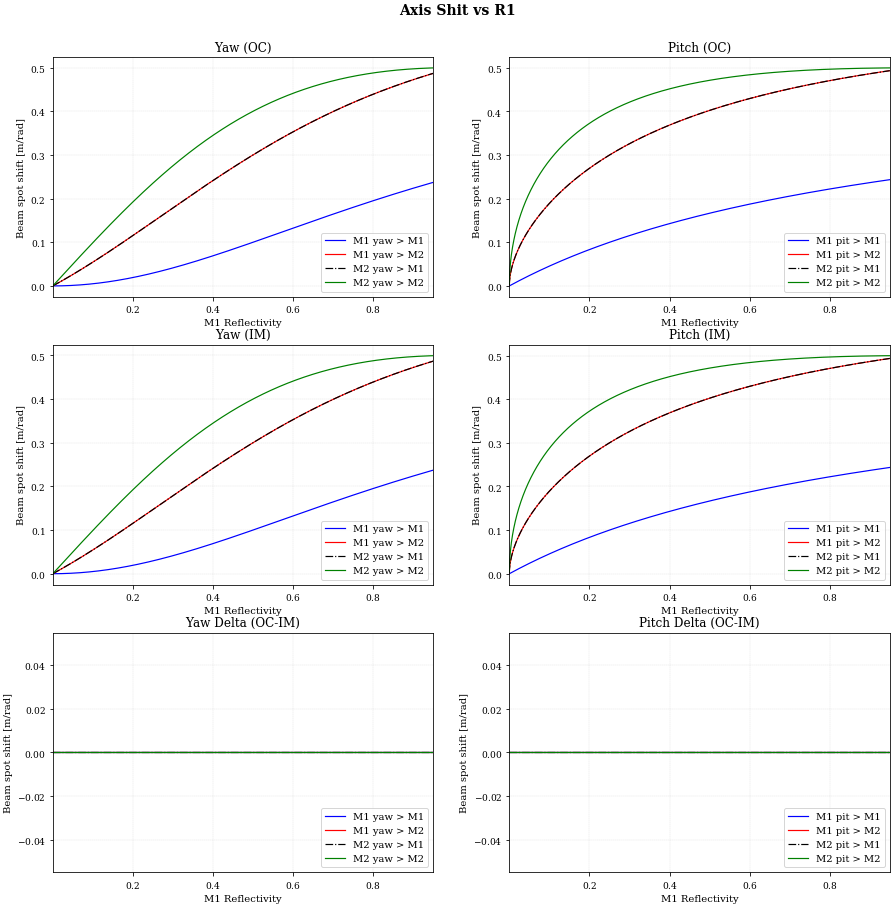

In [211]:

fig, ax = plt.subplots(3,2,figsize=(15,15))
fig.suptitle('Axis Shit vs R1', fontsize=14, fontweight='bold',x=.5,y=.93)

ax[0,0].set_title('Yaw (OC)',fontsize=12)
ax[0,0].plot(ocx.real,-yawM1ocshiftM1,label='M1 yaw > M1')
ax[0,0].plot(ocx.real,yawM1ocshiftM2,label='M1 yaw > M2')
ax[0,0].plot(ocx.real,yawM2ocshiftM1,ls='-.',label='M2 yaw > M1')
ax[0,0].plot(ocx.real,-yawM2ocshiftM2,label='M2 yaw > M2')
# ax[0,0].set_xlim(-1,)
ax[0,0].legend(loc=4)
ax[0,0].set_xlabel('M1 Reflectivity')
ax[0,0].set_ylabel('Beam spot shift [m/rad]')

ax[0,1].set_title('Pitch (OC)',fontsize=12)
ax[0,1].plot(ocx.real,pitM1ocshiftM1,label='M1 pit > M1')
ax[0,1].plot(ocx.real,pitM1ocshiftM2,label='M1 pit > M2')
ax[0,1].plot(ocx.real,-pitM2ocshiftM1,ls='-.',label='M2 pit > M1')
ax[0,1].plot(ocx.real,-pitM2ocshiftM2,label='M2 pit > M2')
# ax[0,1].set_xlim(-1,)
ax[0,1].legend(loc=4)
ax[0,1].set_xlabel('M1 Reflectivity')
ax[0,1].set_ylabel('Beam spot shift [m/rad]')

ax[1,0].set_title('Yaw (IM)',fontsize=12)
ax[1,0].plot(imx.real,-yawM1imshiftM1,label='M1 yaw > M1')
ax[1,0].plot(imx.real,yawM1imshiftM2,label='M1 yaw > M2')
ax[1,0].plot(imx.real,yawM2imshiftM1,ls='-.',label='M2 yaw > M1')
ax[1,0].plot(imx.real,-yawM2imshiftM2,label='M2 yaw > M2')
# ax[1,0].set_xlim(-1,)
ax[1,0].legend(loc=4)
ax[1,0].set_xlabel('M1 Reflectivity')
ax[1,0].set_ylabel('Beam spot shift [m/rad]')

ax[1,1].set_title('Pitch (IM)',fontsize=12)
ax[1,1].plot(imx.real,pitM1imshiftM1,label='M1 pit > M1')
ax[1,1].plot(imx.real,pitM1imshiftM2,label='M1 pit > M2')
ax[1,1].plot(imx.real,-pitM2imshiftM1,ls='-.',label='M2 pit > M1')
ax[1,1].plot(imx.real,-pitM2imshiftM2,label='M2 pit > M2')
# ax[1,1].set_xlim(-1,3)
ax[1,1].legend(loc=4)
ax[1,1].set_xlabel('M1 Reflectivity')
ax[1,1].set_ylabel('Beam spot shift [m/rad]')

ax[2,0].set_title('Yaw Delta (OC-IM)',fontsize=12)
ax[2,0].plot(ocx.real,-yawM1ocshiftM1+yawM1imshiftM1,label='M1 yaw > M1')
ax[2,0].plot(ocx.real,yawM1ocshiftM2-yawM1imshiftM2,label='M1 yaw > M2')
ax[2,0].plot(ocx.real,yawM2ocshiftM1-yawM2imshiftM1,ls='-.',label='M2 yaw > M1')
ax[2,0].plot(ocx.real,-yawM2ocshiftM2+yawM2imshiftM2,label='M2 yaw > M2')
# ax[2,0].set_xlim(-1,)
ax[2,0].legend(loc=4)
ax[2,0].set_xlabel('M1 Reflectivity')
ax[2,0].set_ylabel('Beam spot shift [m/rad]')

ax[2,1].set_title('Pitch Delta (OC-IM)',fontsize=12)
ax[2,1].plot(ocx.real,pitM1ocshiftM1-pitM1imshiftM1,label='M1 pit > M1')
ax[2,1].plot(ocx.real,pitM1ocshiftM2-pitM1imshiftM2,label='M1 pit > M2')
ax[2,1].plot(ocx.real,-pitM2ocshiftM1+pitM2imshiftM1,ls='-.',label='M2 pit > M1')
ax[2,1].plot(ocx.real,-pitM2ocshiftM2+pitM2imshiftM2,label='M2 pit > M2')
# ax[2,1].set_xlim(-1,)
# ax[2,1].set_ylim(-0.00001,0.00001)
ax[2,1].legend(loc=4)
ax[2,1].set_xlabel('M1 Reflectivity')
ax[2,1].set_ylabel('Beam spot shift [m/rad]')



# plt.close()

### Using the cavity parameter detector for finesse

This method fails at R = 0.171483195 (o.x[lastnan]) in both the undercoupled and overcoupled case, which is calculated by Finesse to be a finesse of 1.00423300389682

An approximation of cavity finesse $F = \pi\frac{I_c}{I_0}$ at this R instead returns F = ~3.75

The equation defined for cavity Finesse in Livingreview is (see code implementation in cell below)

$F = \frac{FSR}{FWHM} = \frac{\pi}{2\cdot\arcsin\frac{1-r_1r_1}{2\cdot\sqrt{r_1r_2}}}$

A linearly spaced vector is used in place of finesse for values below this minimum Finesse (0 to 1) to display the beam spot shifts in this space.

 - why do they stop at the same r value?

In [140]:
r1 = ocx.real
r2 = 1
calcfin = np.pi/(2*np.arcsin((1-r1*r2)/(2*np.sqrt(r1*r2))))
print ('M1 R for first finesse value:',o.x[np.argmax(np.where(np.isnan(calcfin)))+1])
print ('finesse at this R value:',calcfin[np.argmax(np.where(np.isnan(calcfin)))+1])


M1 R for first finesse value: 0.171578194
finesse at this R value: 1.0042330038968175


/home/lantyem/anaconda3/envs/env2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Beam spot shift [m/rad]')

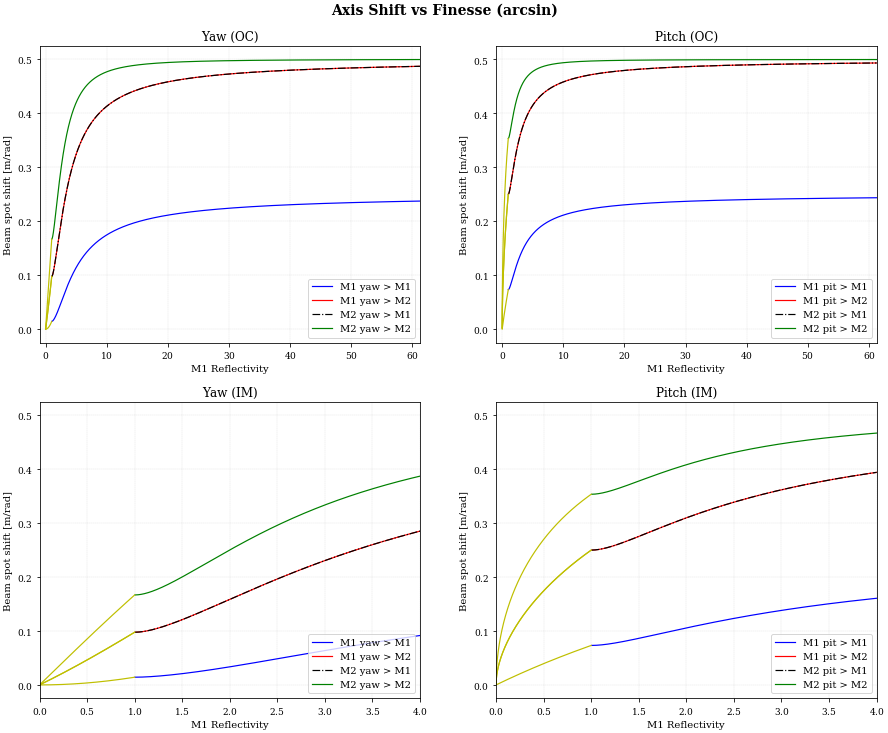

In [207]:
oci = np.argmax(np.where(np.isnan(ocxF.real)))
imi = np.argmax(np.where(np.isnan(ocxF.real)))
ocnanx = np.linspace(0,1,len(ocxF[:oci+1]))
imnanx = np.linspace(0,1,len(imxF[:oci+1]))


fig, ax = plt.subplots(2,2,figsize=(15,12))
fig.suptitle('Axis Shift vs Finesse (arcsin)', fontsize=14, fontweight='bold',x=.5,y=.93)

ax[0,0].set_title('Yaw (OC)',fontsize=12)
ax[0,0].plot(ocxF[oci+1:].real,-yawM1ocshiftM1[oci+1:],label='M1 yaw > M1')
ax[0,0].plot(ocnanx,-yawM1ocshiftM1[:oci+1],c='y')
ax[0,0].plot(ocxF[oci+1:].real,yawM1ocshiftM2[oci+1:],label='M1 yaw > M2')
ax[0,0].plot(ocnanx,yawM1ocshiftM2[:oci+1],c='y')
ax[0,0].plot(ocxF[oci+1:].real,yawM2ocshiftM1[oci+1:],ls='-.',label='M2 yaw > M1')
ax[0,0].plot(ocnanx,yawM2ocshiftM1[:oci+1],c='y')
ax[0,0].plot(ocxF[oci+1:].real,-yawM2ocshiftM2[oci+1:],label='M2 yaw > M2')
ax[0,0].plot(ocnanx,-yawM2ocshiftM2[:oci+1],c='y')
ax[0,0].set_xlim(-1,)
ax[0,0].legend(loc=4)

ax[0,1].set_title('Pitch (OC)',fontsize=12)
ax[0,1].plot(ocxF.real[oci+1:],pitM1ocshiftM1[oci+1:],label='M1 pit > M1')
ax[0,1].plot(ocnanx,pitM1ocshiftM1[:oci+1],c='y')
ax[0,1].plot(ocxF.real[oci+1:],pitM1ocshiftM2[oci+1:],label='M1 pit > M2')
ax[0,1].plot(ocnanx,pitM1ocshiftM2[:oci+1],c='y')
ax[0,1].plot(ocxF.real[oci+1:],-pitM2ocshiftM1[oci+1:],ls='-.',label='M2 pit > M1')
ax[0,1].plot(ocnanx,-pitM2ocshiftM1[:oci+1],c='y')
ax[0,1].plot(ocxF.real[oci+1:],-pitM2ocshiftM2[oci+1:],label='M2 pit > M2')
ax[0,1].plot(ocnanx,-pitM2ocshiftM2[:oci+1],c='y')
ax[0,1].set_xlim(-1,)
ax[0,1].legend(loc=4)

ax[1,0].set_title('Yaw (IM)',fontsize=12)
ax[1,0].plot(imxF.real[imi+1:],-yawM1imshiftM1[imi+1:],label='M1 yaw > M1')
ax[1,0].plot(imnanx,-yawM1imshiftM1[:imi+1],c='y')
ax[1,0].plot(imxF.real[imi+1:],yawM1imshiftM2[imi+1:],label='M1 yaw > M2')
ax[1,0].plot(imnanx,yawM1imshiftM2[:imi+1],c='y')
ax[1,0].plot(imxF.real[imi+1:],yawM2imshiftM1[imi+1:],ls='-.',label='M2 yaw > M1')
ax[1,0].plot(imnanx,yawM2imshiftM1[:imi+1],c='y')
ax[1,0].plot(imxF.real[imi+1:],-yawM2imshiftM2[imi+1:],label='M2 yaw > M2')
ax[1,0].plot(imnanx,-yawM2imshiftM2[:imi+1],c='y')
ax[1,0].set_xlim(0,4)
ax[1,0].legend(loc=4)

ax[1,1].set_title('Pitch (IM)',fontsize=12)
ax[1,1].plot(imxF.real[imi+1:],pitM1imshiftM1[imi+1:],label='M1 pit > M1')
ax[1,1].plot(imnanx,pitM1imshiftM1[:imi+1],c='y')
ax[1,1].plot(imxF.real[imi+1:],pitM1imshiftM2[imi+1:],label='M1 pit > M2')
ax[1,1].plot(imnanx,pitM1imshiftM2[:imi+1],c='y')
ax[1,1].plot(imxF.real[imi+1:],-pitM2imshiftM1[imi+1:],ls='-.',label='M2 pit > M1')
ax[1,1].plot(imnanx,-pitM2imshiftM1[:imi+1],c='y')
ax[1,1].plot(imxF.real[imi+1:],-pitM2imshiftM2[imi+1:],label='M2 pit > M2')
ax[1,1].plot(imnanx,-pitM2imshiftM2[:imi+1],c='y')
# ax[1,1].set_xlim(-1,)
ax[1,1].set_xlim(0,4)
ax[1,1].legend(loc=4)



ax[0,0].set_xlabel('M1 Reflectivity')
ax[0,0].set_ylabel('Beam spot shift [m/rad]')
ax[0,1].set_xlabel('M1 Reflectivity')
ax[0,1].set_ylabel('Beam spot shift [m/rad]')
ax[1,0].set_xlabel('M1 Reflectivity')
ax[1,0].set_ylabel('Beam spot shift [m/rad]')
ax[1,1].set_xlabel('M1 Reflectivity')
ax[1,1].set_ylabel('Beam spot shift [m/rad]')


### Approximations for Finesse

Only plotting OC case now, having no difference between OC and IM cases in previous plots. Approximations used:
 - $F = \frac{I_c}{I_0}$, calculated using pd at input of cavity and inside to get input and circulating power.
 - $F = \frac{4\cdot T_1}{(T_1+V)^2}$
 - $F = \frac{\pi\sqrt{r_1r_2}}{1-r_1r_2}$
 
A comparison to the Finesse outputs from (again, OC case) added with alpha controllable.

In [185]:
apkat = ockat.deepcopy()

o = apkat.run()
r1 = o.x.real
r2 = 1
t1 = 1-r1
v = o['c1_x_loss']

xF_I = o['circ']/o['in']
xF_V = (4*np.pi*t1)/(t1+v)**2
xF_r = (np.pi*np.sqrt(r1*r2))/(1-r1*r2)


Text(0, 0.5, 'Beam spot shift [m/rad]')

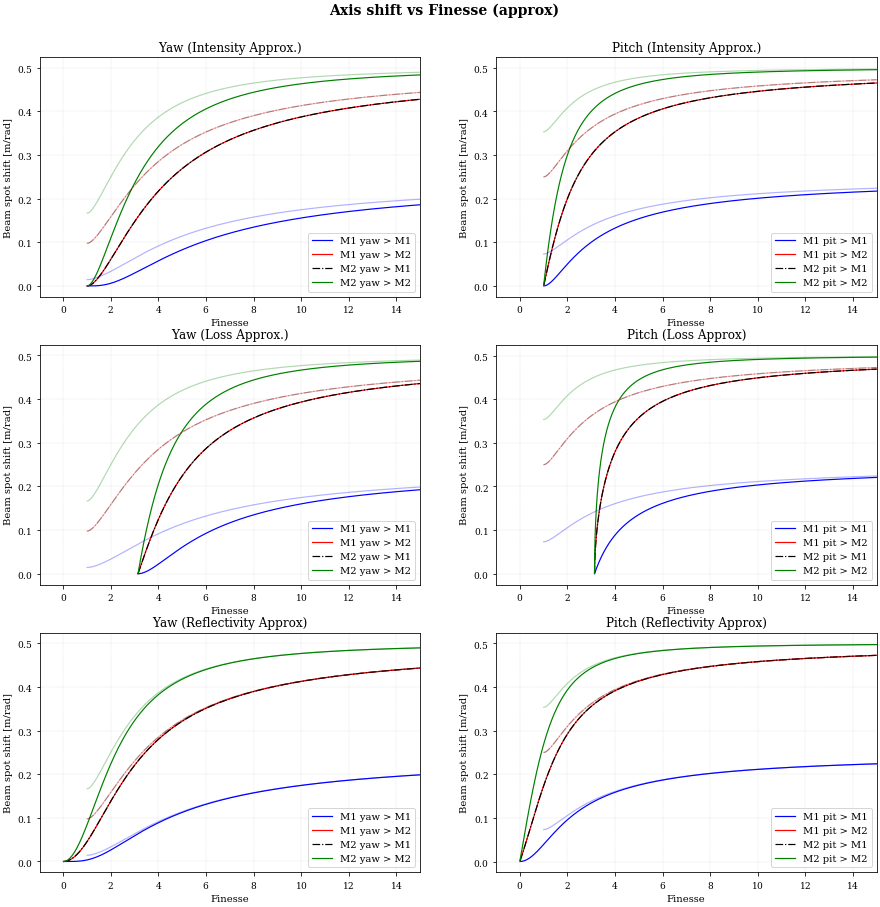

In [214]:
fig, ax = plt.subplots(3,2,figsize=(15,15))
fig.suptitle('Axis shift vs Finesse (approx)', fontsize=14, fontweight='bold',x=.5,y=.93)
upperlim = 15
alpha = 0.3

ax[0,0].set_title('Yaw (Intensity Approx.)',fontsize=12)
ax[0,0].plot(xF_I,-yawM1ocshiftM1,label='M1 yaw > M1')
ax[0,0].plot(xF_I,yawM1ocshiftM2,label='M1 yaw > M2')
ax[0,0].plot(xF_I,yawM2ocshiftM1,ls='-.',label='M2 yaw > M1')
ax[0,0].plot(xF_I,-yawM2ocshiftM2,label='M2 yaw > M2')
ax[0,0].set_xlim(-1,upperlim)
ax[0,0].legend(loc=4)

ax[0,1].set_title('Pitch (Intensity Approx.)',fontsize=12)
ax[0,1].plot(xF_I,pitM1ocshiftM1,label='M1 pit > M1')
ax[0,1].plot(xF_I,pitM1ocshiftM2,label='M1 pit > M2')
ax[0,1].plot(xF_I,-pitM2ocshiftM1,ls='-.',label='M2 pit > M1')
ax[0,1].plot(xF_I,-pitM2ocshiftM2,label='M2 pit > M2')
ax[0,1].set_xlim(-1,upperlim)
ax[0,1].legend(loc=4)

ax[1,0].set_title('Yaw (Loss Approx.)',fontsize=12)
ax[1,0].plot(xF_V,-yawM1ocshiftM1,label='M1 yaw > M1')
ax[1,0].plot(xF_V,yawM1ocshiftM2,label='M1 yaw > M2')
ax[1,0].plot(xF_V,yawM2ocshiftM1,ls='-.',label='M2 yaw > M1')
ax[1,0].plot(xF_V,-yawM2ocshiftM2,label='M2 yaw > M2')
ax[1,0].set_xlim(-1,upperlim)
ax[1,0].legend(loc=4)

ax[1,1].set_title('Pitch (Loss Approx)',fontsize=12)
ax[1,1].plot(xF_V,pitM1ocshiftM1,label='M1 pit > M1')
ax[1,1].plot(xF_V,pitM1ocshiftM2,label='M1 pit > M2')
ax[1,1].plot(xF_V,-pitM2ocshiftM1,ls='-.',label='M2 pit > M1')
ax[1,1].plot(xF_V,-pitM2ocshiftM2,label='M2 pit > M2')
ax[1,1].set_xlim(-1,upperlim)
# ax[1,1].set_xlim(1,4)
ax[1,1].legend(loc=4)

ax[2,0].set_title('Yaw (Reflectivity Approx)',fontsize=12)
ax[2,0].plot(xF_r,-yawM1ocshiftM1,label='M1 yaw > M1')
ax[2,0].plot(xF_r,yawM1ocshiftM2,label='M1 yaw > M2')
ax[2,0].plot(xF_r,yawM2ocshiftM1,ls='-.',label='M2 yaw > M1')
ax[2,0].plot(xF_r,-yawM2ocshiftM2,label='M2 yaw > M2')
ax[2,0].set_xlim(-1,upperlim)
ax[2,0].legend(loc=4)

ax[2,1].set_title('Pitch (Reflectivity Approx)',fontsize=12)
ax[2,1].plot(xF_r,pitM1ocshiftM1,label='M1 pit > M1')
ax[2,1].plot(xF_r,pitM1ocshiftM2,label='M1 pit > M2')
ax[2,1].plot(xF_r,-pitM2ocshiftM1,ls='-.',label='M2 pit > M1')
ax[2,1].plot(xF_r,-pitM2ocshiftM2,label='M2 pit > M2')
ax[2,1].set_xlim(-1,upperlim)
# ax[1,1].set_xlim(1,4)
ax[2,1].legend(loc=4)

### Comparison plots
for i in range(3):
    ax[i,0].plot(ocxF.real,-yawM1ocshiftM1,alpha=alpha,c='b')
    ax[i,0].plot(ocxF.real,yawM1ocshiftM2,alpha=alpha,c='r')
    ax[i,0].plot(ocxF.real,yawM2ocshiftM1,ls='-.',alpha=alpha,c='k')
    ax[i,0].plot(ocxF.real,-yawM2ocshiftM2,alpha=alpha,c='g')

    ax[i,1].plot(ocxF.real,pitM1ocshiftM1,alpha=alpha,c='b')
    ax[i,1].plot(ocxF.real,pitM1ocshiftM2,alpha=alpha,c='r')
    ax[i,1].plot(ocxF.real,-pitM2ocshiftM1,ls='-.',alpha=alpha,c='k')
    ax[i,1].plot(ocxF.real,-pitM2ocshiftM2,alpha=alpha,c='g')

ax[0,0].set_xlabel('Finesse')
ax[0,0].set_ylabel('Beam spot shift [m/rad]')
ax[0,1].set_xlabel('Finesse')
ax[0,1].set_ylabel('Beam spot shift [m/rad]')
ax[1,0].set_xlabel('Finesse')
ax[1,0].set_ylabel('Beam spot shift [m/rad]')
ax[1,1].set_xlabel('Finesse')
ax[1,1].set_ylabel('Beam spot shift [m/rad]')
ax[2,0].set_xlabel('Finesse')
ax[2,0].set_ylabel('Beam spot shift [m/rad]')
ax[2,1].set_xlabel('Finesse')
ax[2,1].set_ylabel('Beam spot shift [m/rad]')
# plt.close()

In [64]:
R1 = 0.18
R2 = 1
((2*max(fsr)/np.pi)*(np.arcsin((1-R1*R2)/(2*np.sqrt(R1*R2)))))

(500325035.196319+0j)

[ 1.00000999+0.j  1.00010496+0.j  1.00019994+0.j ... 19.21363716+0.j
 19.24953754+0.j 19.28557464+0.j]


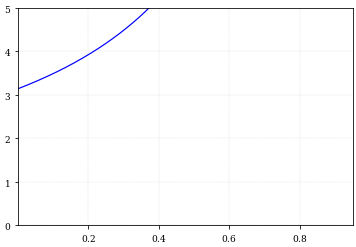

In [99]:
plt.plot(o.x,np.pi*o['circ']/o['in'])
plt.ylim(0,5)

In [ ]:
plt.figure()
plt.semilogx(xout["c1_x_finesse"],-m1shiftx,label='Shift on M1')
plt.semilogx(xout["c1_x_finesse"],m2shiftx,label='Shift on M2')
plt.legend()
plt.xlabel("Finesse")
plt.ylabel("Response [m/rad]")
plt.title("M1 dithered in x direction")

plt.figure()
plt.semilogx(yout["c1_x_finesse"],m1shifty,label='Shift on M1')
plt.semilogx(yout["c1_x_finesse"],m2shifty,label='Shift on M2')
plt.legend()
plt.xlabel("Finesse")
plt.ylabel("Response [m/rad]")
plt.title("M1 dithered in y direction")

In [ ]:
plt.figure()
plt.semilogx(xout["c1_x_finesse"],-m1shiftx,label='Shift on M1')
plt.semilogx(xout["c1_x_finesse"],m2shiftx,label='Shift on M2')
plt.legend()
plt.xlabel("Finesse")
plt.ylabel("Response [m/rad]")
plt.title("M1 dithered in x direction")

plt.figure()
plt.semilogx(yout["c1_x_finesse"],m1shifty,label='Shift on M1')
plt.semilogx(yout["c1_x_finesse"],m2shifty,label='Shift on M2')
plt.legend()
plt.xlabel("Finesse")
plt.ylabel("Response [m/rad]")
plt.title("M1 dithered in y direction")

In [ ]:
xout.plot(detectors=['Tt'])